# SVI with 2D Gaussian Process Prior

`**Warning**`: This notebook is less refined than the previous notebooks. It's an older book that I'm adding as an additional resource to users and has not been checked for accuracy.

Besides that, there are two issues with this code:

1. During the SVI, the `PRNGKey` used to sample derivatives does not change. This can be fixed by manually adding the `PRNGKey` as we did in the previous notebook. 
2. We can save a lot more time and memory by running this with a sparse GP. In this way, during the SVI, we first sample from the sparse GP. This ensures that the SVI `guide` is tracking only the inducing points. After that, we can use the GP conditioned on the inducing points to sample over the function-values at the observation values $x$ and derivatives at the derivative values $x_{D}$. 

These changes are easy to implement if you understand the previous notebooks and the first two notebooks in the [sparse-tinygp][1] repo. I am not implementing these fixes because this will be done in another repo that I plan to publish in the future. This repo would contain the results from the project that required me to learn GPs in the first place.

<!-- ### References -->

[1]: <https://github.com/edwarddramirez/sparse-tinygp> "sparse-tinygp"

# Cartesian GP Fitting (Radial Derivative Regularization)

In [1]:
import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for plotting
import jax # for faster numerical operations
import jax.numpy as jnp # for numpy-like syntax
import numpyro # for inference and probabilistic programming
import tinygp  # for Gaussian process regression
from tinygp import GaussianProcess, kernels, transforms
import numpyro.distributions as dist
import matplotlib as mpl

/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text(0.5, 1.0, 'True Rate')

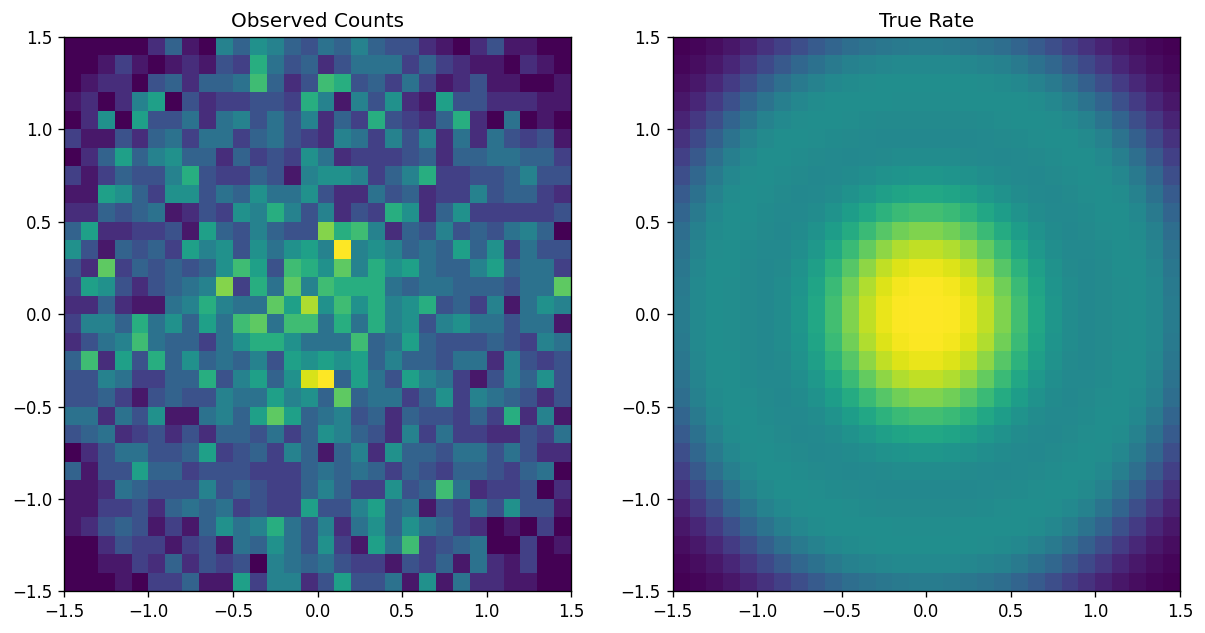

In [2]:
# plot the true function
x1_plt = np.linspace(-1.5, 1.5, 31)
x2_plt = np.linspace(-1.5, 1.5, 31)
x1_c = 0.5 * (x1_plt[1:] + x1_plt[:-1]) ; x2_c = 0.5 * (x2_plt[1:] + x2_plt[:-1])
x1, x2 = np.meshgrid(x1_c, x2_c)
x = np.stack([x1, x2], axis=-1)
x_mag = np.linalg.norm(x, axis = -1)
log_rate = -0.4 * x_mag**2. * np.abs(2. + np.cos(8. * x_mag**(0.5)))
rate = 10 * np.exp(log_rate)
y_obs = np.random.poisson(rate)

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)
ax.pcolormesh(x1_plt, x2_plt, y_obs, cmap='viridis')
ax.set_title('Observed Counts')

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, rate, cmap='viridis')
ax.set_title('True Rate')

Text(0, 0.5, 'y')

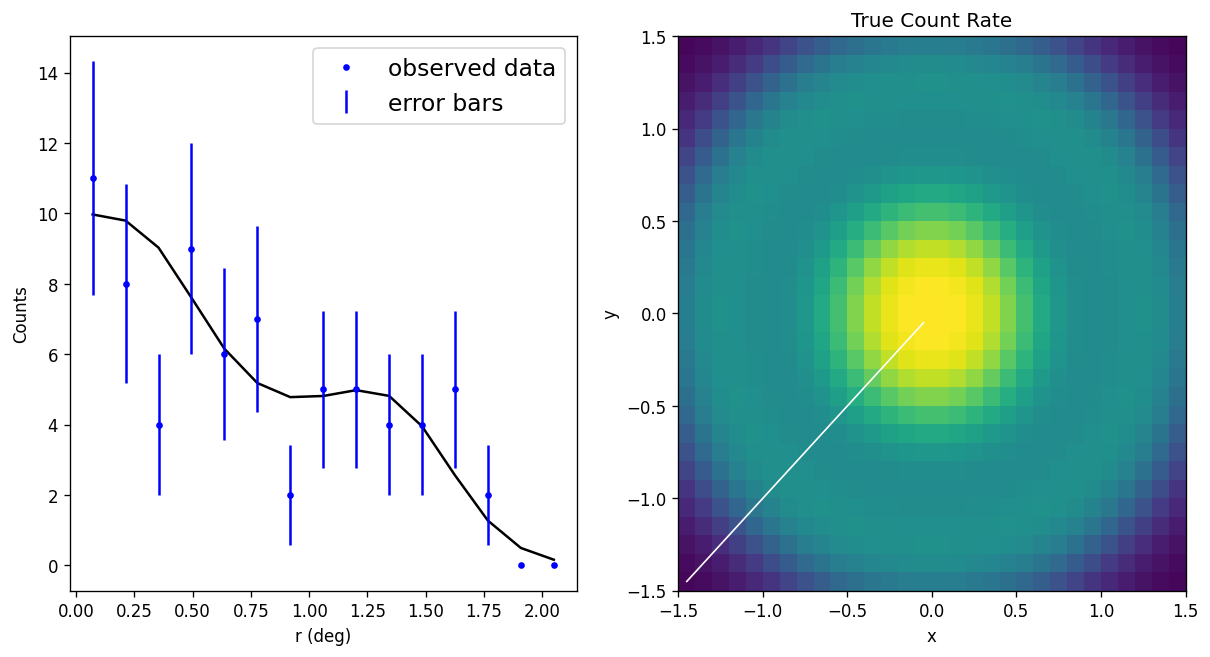

In [3]:
# Plot fit curves on a slice of x-values

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)

Nx = len(x1_c)
ny = np.arange(0,int(Nx/2),1)
y = rate

r = np.linalg.norm(x[ny,ny,:], axis = -1)
ax.plot(r, y[ny,ny], c = 'k')
ax.plot(r, y_obs[ny,ny], 'b.', label='observed data')
ax.errorbar(r, y_obs[ny,ny], yerr = np.sqrt(y_obs[ny,ny] ), c = 'b', fmt = 'none', label='error bars')
ax.set_xlabel('r (deg)')
ax.set_ylabel('Counts')
ax.legend(fontsize = 14)

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=np.max(y)))
ax.plot(x[ny,ny,0], x[ny,ny,1], c = 'w', lw = 1)
ax.set_title('True Count Rate')
ax.set_xlabel('x')
ax.set_ylabel('y')

In [4]:
class DerivativeKernel(kernels.Kernel):
    def __init__(self, kernel):
        self.kernel = kernel
    def evaluate(self, X1, X2):
        x1, y1, d1x, d1y = X1
        x2, y2, d2x, d2y = X2
        # Evaluate the kernel matrix and all of its relevant derivatives
        K = self.kernel.evaluate(jnp.array([x1,y1]), jnp.array([x2,y2]))
        # For stationary kernels, these are related just by a minus sign, but we'll
        # evaluate them both separately for generality's sake
        dK_dx2 = jax.grad(lambda x2_: self.kernel.evaluate(jnp.array([x1,y1]),jnp.array([x2_,y2])))(x2)
        dK_dx1 = jax.grad(lambda x1_: self.kernel.evaluate(jnp.array([x1_,y1]),jnp.array([x2,y2])))(x1)
        d2K_dx1dx2 = (jax.grad( lambda x2_: 
            ( jax.grad( lambda x1_: self.kernel.evaluate(jnp.array([x1_,y1]),jnp.array([x2_,y2]))) )(x1) 
            ) )(x2) 
        
        dK_dy2 = jax.grad(lambda y2_: self.kernel.evaluate(jnp.array([x1,y1]),jnp.array([x2,y2_])))(y2)
        dK_dy1 = jax.grad(lambda y1_: self.kernel.evaluate(jnp.array([x1,y1_]),jnp.array([x2,y2])))(y1)
        d2K_dy1dy2 = (jax.grad( lambda y2_: 
            ( jax.grad( lambda y1_: self.kernel.evaluate(jnp.array([x1,y1_]),jnp.array([x2,y2_]))) )(y1) 
            ) )(y2) 
        
        d2K_dx1dy2 = (jax.grad( lambda y2_: 
            ( jax.grad( lambda x1_: self.kernel.evaluate(jnp.array([x1_,y1]),jnp.array([x2,y2_]))) )(x1) 
            ) )(y2) 
        d2K_dy1dx2 = (jax.grad( lambda x2_: 
            ( jax.grad( lambda y1_: self.kernel.evaluate(jnp.array([x1,y1_]),jnp.array([x2_,y2]))) )(y1) 
            ) )(x2) 
        
        return jnp.where(d1x, 
                         jnp.where(d2x, d2K_dx1dx2, jnp.where(d2y, d2K_dx1dy2, dK_dx1)),
                         jnp.where(d1y, jnp.where(d2x, d2K_dy1dx2, jnp.where(d2y, d2K_dy1dy2, dK_dy1)), 
                                   jnp.where(d2x, dK_dx2, jnp.where(d2y, dK_dy2, K)))
                                   )

In [5]:
# SVI fit to 2D Poisson data with Gaussian Process prior
# on log_rate and its derivatives, NOT subject to derivative-regularization

# NOTE: To use different kernels, need to change distance as in 02_2d_deriv_gp.ipynb

Nx, Ny = x.shape[:-1]
x_f = x.reshape((Nx*Ny,2))
y_obs_f = y_obs.reshape((Nx*Ny,))

def model(x, y=None):
    Nx = x.shape[0]
    Nx2 = 2 * Nx

    log_amp = numpyro.param('log_amp', jnp.ones(()))
    log_scale = numpyro.param('log_scale', jnp.ones(()))

    # Set up the augmented input consisting of position and boolean for derivative
    x3 = jnp.concatenate([x,x,x])
    d3x = jnp.concatenate([jnp.zeros(x.shape[0]),jnp.ones(x.shape[0]),jnp.zeros(x.shape[0])])
    d3y = jnp.concatenate([jnp.zeros(x.shape[0]),jnp.zeros(x.shape[0]),jnp.ones(x.shape[0])])
    x_aug = jnp.vstack([x3.T,d3x.T,d3y.T]).T

    # load joint kernel from the original function kernel
    base_kernel = jnp.exp(log_amp) * transforms.Linear(jnp.exp(log_scale), kernels.ExpSquared())
    kernel = DerivativeKernel(base_kernel)
    gp = GaussianProcess(kernel, x_aug[:Nx], diag=1e-3) 

    # sample log_rate from GP
    log_rate = numpyro.sample("log_rate", gp.numpyro_dist())

    # define the likelihood
    rate = jnp.exp(log_rate)
    numpyro.sample("obs", dist.Poisson(rate), obs=y) # can't use numpyro.factor for svi

# guide of posterior distribution of log_rate and log_rate_deriv
def guide(x, y=None):
    mu = numpyro.param(
        "log_rate_mu", jnp.zeros((x.shape[0],))
    )
    sigma = numpyro.param(
        "log_rate_sigma",
        jnp.ones((x.shape[0],)),
        constraint=dist.constraints.positive,
    )

    numpyro.sample("log_rate", dist.Independent(dist.Normal(mu, sigma), 1))

# run SVI
optim = numpyro.optim.Adam(0.01)
svi = numpyro.infer.SVI(model, guide, optim, numpyro.infer.Trace_ELBO(10))
results = svi.run(jax.random.PRNGKey(5573), 12000, x_f, y=y_obs_f, progress_bar=True)

100%|██████████| 12000/12000 [00:59<00:00, 202.55it/s, init loss: 358388.9375, avg. loss [11401-12000]: 2500.7676]


In [6]:
# load optimized guide params
mu = results.params["log_rate_mu"]
sigma = results.params["log_rate_sigma"]

mu_r = mu.reshape(Nx,Ny)
sigma_r = sigma.reshape(Nx,Ny)

Text(0.5, 1.0, 'Counts')

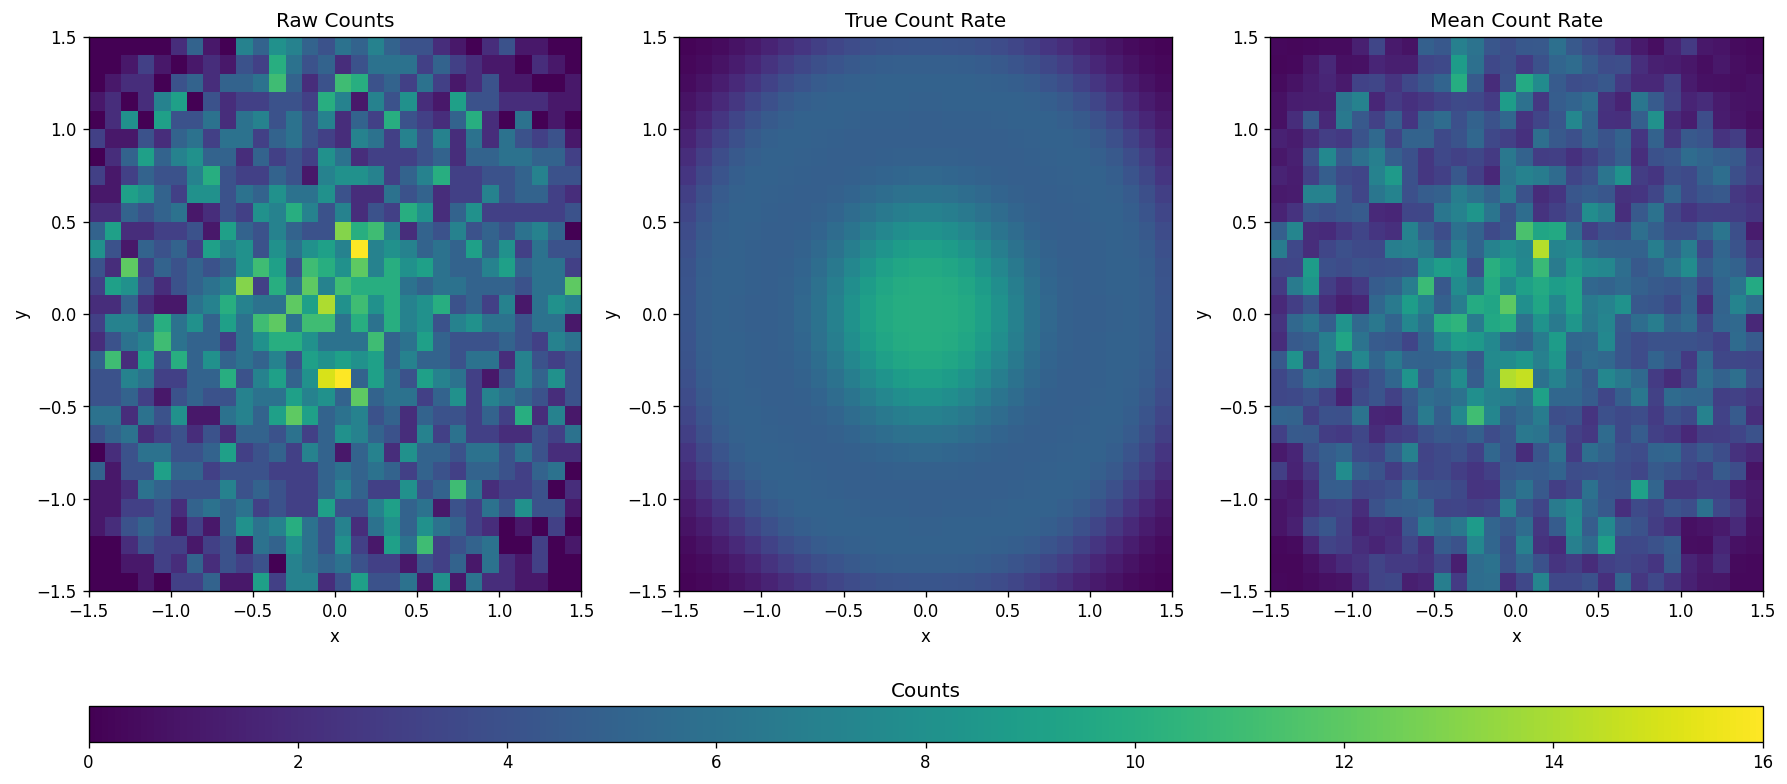

In [7]:
# plot raw count map, true rate map, and mean rate map from posterior of log_rate

vmax = np.max([np.max(y_obs), np.max(rate), np.max(np.exp(mu_r))])
fig = plt.figure(figsize=(18, 6), dpi= 120)
ax1 = fig.add_subplot(131)
plot1 = plt.pcolormesh(x1_plt, x2_plt, y_obs, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax1.set_title('Raw Counts')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2 = fig.add_subplot(132)
plot2 = plt.pcolormesh(x1_plt, x2_plt, rate, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax2.set_title('True Count Rate')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax3 = fig.add_subplot(133)
plot3 = plt.pcolormesh(x1_plt, x2_plt, np.exp(mu_r), cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax3.set_title('Mean Count Rate')
ax3.set_xlabel('x')
ax3.set_ylabel('y')

p0 = ax1.get_position().get_points().flatten()
p1 = ax2.get_position().get_points().flatten()
p2 = ax3.get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], -0.1, p2[2]-p0[0], 0.05])

plt.colorbar(cax=ax_cbar, orientation='horizontal')
ax_cbar.set_title('Counts')

Text(0, 0.5, 'y')

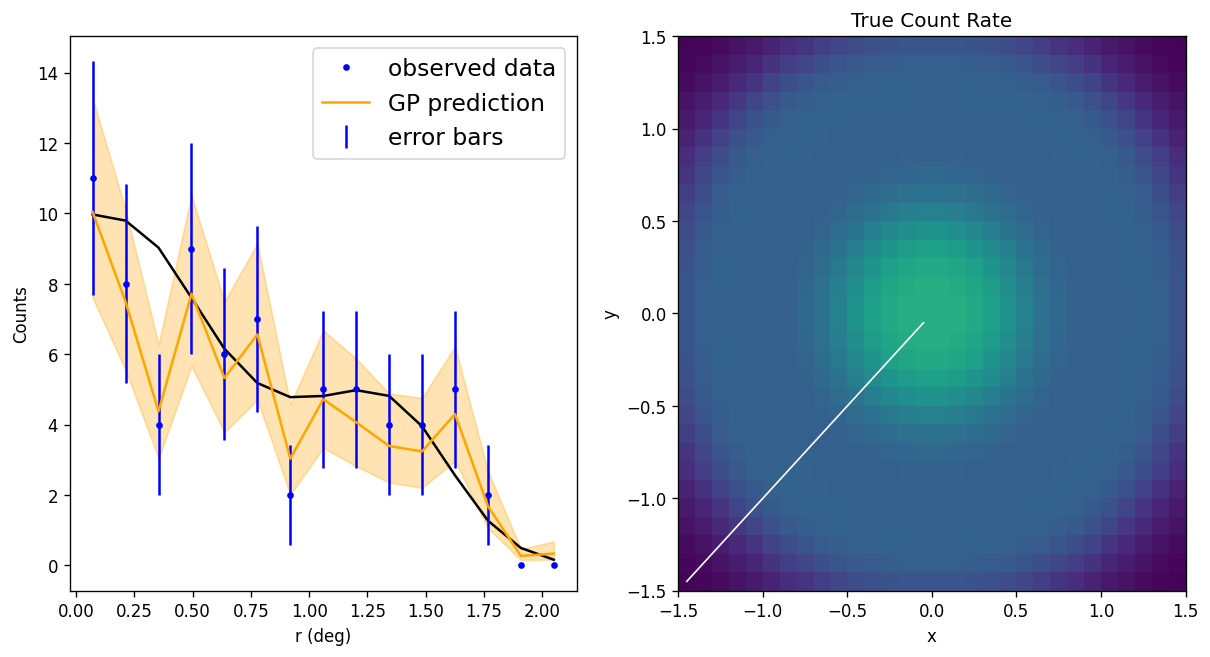

In [8]:
# Plot fit curves on a slice of increasing radius

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)

Nx = len(x1_c)
ny = np.arange(0,int(Nx/2),1)
y = rate

r = np.linalg.norm(x[ny,ny,:], axis = -1)
ax.plot(r, y[ny,ny], c = 'k')
ax.plot(r, y_obs[ny,ny], 'b.', label='observed data')
ax.errorbar(r, y_obs[ny,ny], yerr = np.sqrt(y_obs[ny,ny] ), c = 'b', fmt = 'none', label='error bars')
ax.plot(r, np.exp(mu_r)[ny,ny], c = 'orange', label = 'GP prediction')
ax.fill_between(r, np.exp(mu_r - sigma_r)[ny,ny], np.exp(mu_r + sigma_r)[ny,ny], color = 'orange', alpha = 0.3)
ax.set_xlabel('r (deg)')
ax.set_ylabel('Counts')
ax.legend(fontsize = 14)

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax.plot(x[ny,ny,0], x[ny,ny,1], c = 'w', lw = 1)
ax.set_title('True Count Rate')
ax.set_xlabel('x')
ax.set_ylabel('y')

Text(0, 0.5, 'y')

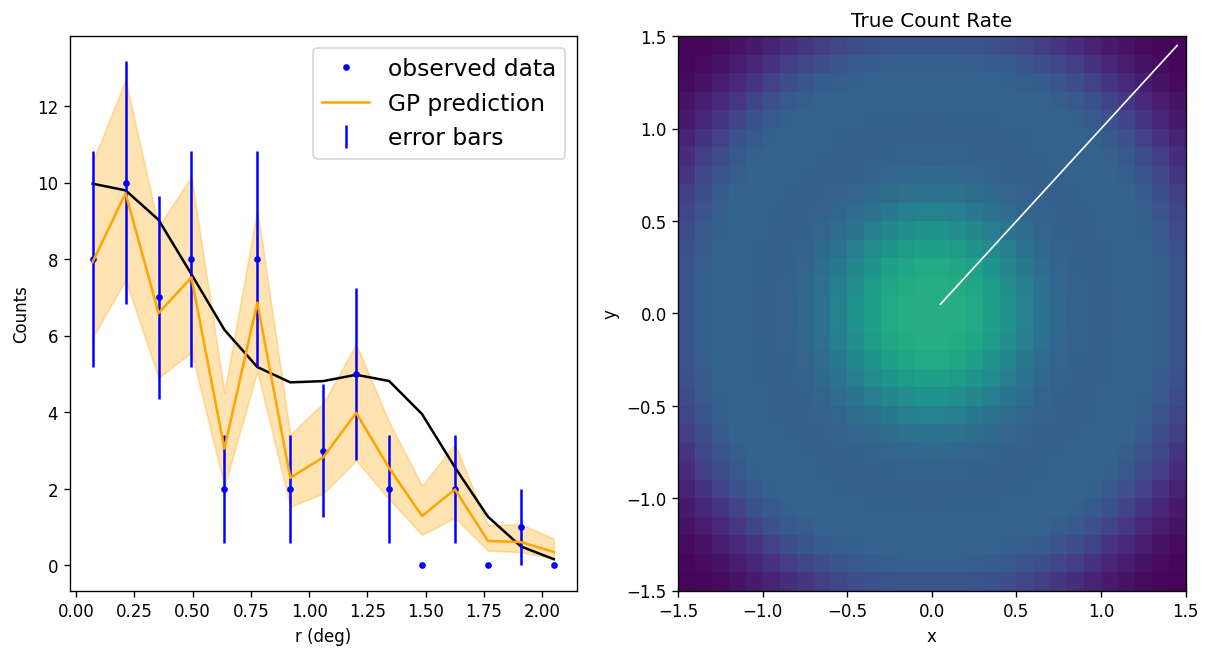

In [9]:
# Plot fit curves on a slice of increasing radius

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)

Nx = len(x1_c)
ny = np.arange(int(Nx/2),int(Nx),1)
y = rate

r = np.linalg.norm(x[ny,ny,:], axis = -1)
ax.plot(r, y[ny,ny], c = 'k')
ax.plot(r, y_obs[ny,ny], 'b.', label='observed data')
ax.errorbar(r, y_obs[ny,ny], yerr = np.sqrt(y_obs[ny,ny] ), c = 'b', fmt = 'none', label='error bars')
ax.plot(r, np.exp(mu_r)[ny,ny], c = 'orange', label = 'GP prediction')
ax.fill_between(r, np.exp(mu_r - sigma_r)[ny,ny], np.exp(mu_r + sigma_r)[ny,ny], color = 'orange', alpha = 0.3)
ax.set_xlabel('r (deg)')
ax.set_ylabel('Counts')
ax.legend(fontsize = 14)

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax.plot(x[ny,ny,0], x[ny,ny,1], c = 'w', lw = 1)
ax.set_title('True Count Rate')
ax.set_xlabel('x')
ax.set_ylabel('y')



In [10]:
# SVI fit to 2D Poisson data with Gaussian Process prior
# on log_rate and its derivatives, subject to derivative-regularization

# NOTE: To use different kernels, need to change distance as in 02_2d_deriv_gp.ipynb

Nx, Ny = x.shape[:-1]
x_f = x.reshape((Nx*Ny,2))
y_obs_f = y_obs.reshape((Nx*Ny,))

jax.config.update("jax_enable_x64", False)

def model(x, y=None):
    Nx = x.shape[0]
    Nx2 = 2 * Nx

    log_amp = numpyro.param('log_amp', jnp.ones(()))
    log_scale = numpyro.param('log_scale', jnp.ones(()))

    # Set up the augmented input consisting of position and boolean for derivative
    x3 = jnp.concatenate([x,x,x])
    d3x = jnp.concatenate([jnp.zeros(x.shape[0]),jnp.ones(x.shape[0]),jnp.zeros(x.shape[0])])
    d3y = jnp.concatenate([jnp.zeros(x.shape[0]),jnp.zeros(x.shape[0]),jnp.ones(x.shape[0])])
    x_aug = jnp.vstack([x3.T,d3x.T,d3y.T]).T

    # load joint kernel from the original function kernel
    base_kernel = jnp.exp(log_amp) * transforms.Linear(jnp.exp(log_scale), kernels.ExpSquared())
    kernel = DerivativeKernel(base_kernel)
    gp = GaussianProcess(kernel, x_aug[:Nx], diag=1e-3) 

    # sample log_rate from GP
    log_rate = numpyro.sample("log_rate", gp.numpyro_dist())

    # define the likelihood
    rate = jnp.exp(log_rate)
    numpyro.sample("obs", dist.Poisson(rate), obs=y) # can't use numpyro.factor for svi

    # sample log_rate_px from GP conditioned on log_rate
    _, gp_cond_px = gp.condition(log_rate, x_aug[Nx:Nx2],diag=1e-3) # condition GP on log_rate and sample derivatives at x_aug[Nx:]
    log_rate_px = gp_cond_px.sample(jax.random.PRNGKey(5573)) # log_rate_deriv 
    rate_px = rate * log_rate_px # rate_deriv

    # sample log_rate_py from GP conditioned on log_rate and log_rate_px
    _, gp_cond_py = gp_cond_px.condition(log_rate_px, x_aug[Nx2:], diag=1e-3) # condition GP on log_rate and sample derivatives at x_aug[Nx:]
    log_rate_py = gp_cond_py.sample(jax.random.PRNGKey(5573)) # log_rate_deriv
    rate_py = rate * log_rate_py # rate_deriv

    # define the constraint
    x_mag = jnp.sqrt(jnp.sum(x**2., axis=1))
    x_hat = x / x_mag[:,None]
    rate_p = rate_px * x_hat[:,0] + rate_py * x_hat[:,1]
    numpyro.factor("constraint", -10. * jnp.sum(jnp.where(rate_p > 0, rate_p, 0.)))

# guide of posterior distribution of log_rate and log_rate_deriv
def guide(x, y=None):
    mu = numpyro.param(
        "log_rate_mu", jnp.zeros((x.shape[0],))
    )
    sigma = numpyro.param(
        "log_rate_sigma",
        jnp.ones((x.shape[0],)),
        constraint=dist.constraints.positive,
    )

    numpyro.sample("log_rate", dist.Independent(dist.Normal(mu, sigma), 1))

# run SVI
optim = numpyro.optim.Adam(0.01)
svi = numpyro.infer.SVI(model, guide, optim, numpyro.infer.Trace_ELBO(10))
results = svi.run(jax.random.PRNGKey(5573), 12000, x_f, y=y_obs_f, progress_bar=True)

100%|██████████| 12000/12000 [06:11<00:00, 32.33it/s, init loss: 382487.2500, avg. loss [11401-12000]: 2058.1179]


In [11]:
# load optimized guide params
mu_c = results.params["log_rate_mu"]
sigma_c = results.params["log_rate_sigma"]

mu_c_r = mu_c.reshape(Nx,Ny)
sigma_c_r = sigma_c.reshape(Nx,Ny)

Text(0.5, 1.0, 'Counts')

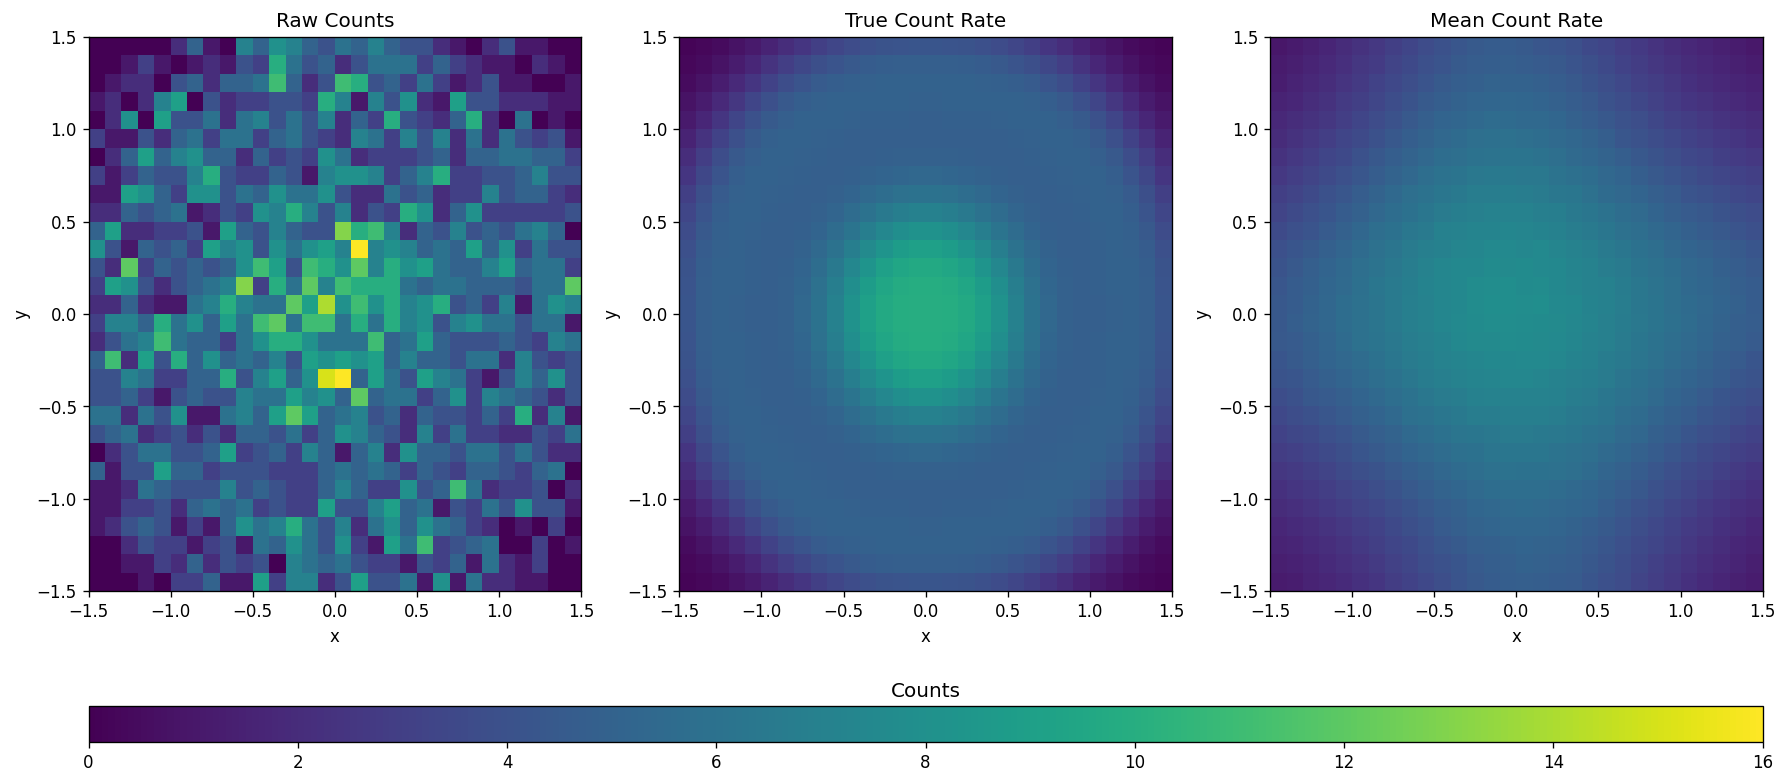

In [12]:
# plot raw count map, true rate map, and mean rate map from posterior of log_rate

import matplotlib as mpl

vmax = np.max([np.max(y_obs), np.max(rate), np.max(np.exp(mu_c_r))])
fig = plt.figure(figsize=(18, 6), dpi= 120)
ax1 = fig.add_subplot(131)
plot1 = plt.pcolormesh(x1_plt, x2_plt, y_obs, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax1.set_title('Raw Counts')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2 = fig.add_subplot(132)
plot2 = plt.pcolormesh(x1_plt, x2_plt, rate, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax2.set_title('True Count Rate')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax3 = fig.add_subplot(133)
plot3 = plt.pcolormesh(x1_plt, x2_plt, np.exp(mu_c_r), cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax3.set_title('Mean Count Rate')
ax3.set_xlabel('x')
ax3.set_ylabel('y')

p0 = ax1.get_position().get_points().flatten()
p1 = ax2.get_position().get_points().flatten()
p2 = ax3.get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], -0.1, p2[2]-p0[0], 0.05])

plt.colorbar(cax=ax_cbar, orientation='horizontal')
ax_cbar.set_title('Counts')

Text(0, 0.5, 'y')

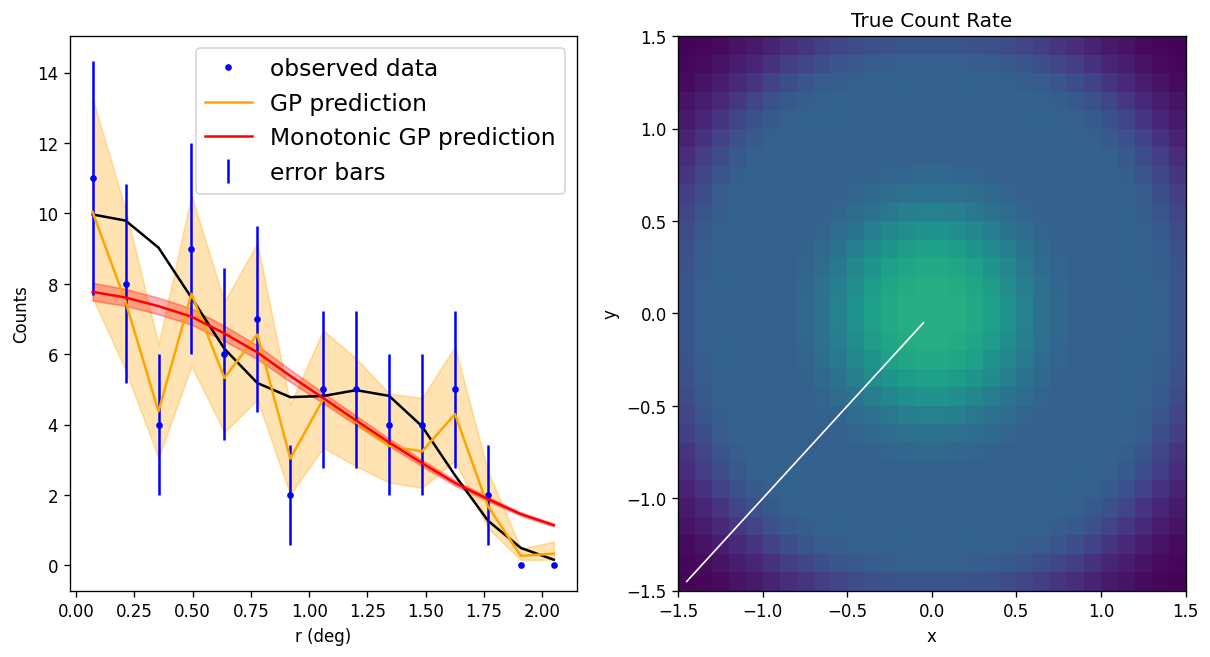

In [13]:
# Plot fit curves on a slice of increasing radius

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)

Nx = len(x1_c)
ny = np.arange(0,int(Nx/2),1)
y = rate

r = np.linalg.norm(x[ny,ny,:], axis = -1)
ax.plot(r, y[ny,ny], c = 'k')
ax.plot(r, y_obs[ny,ny], 'b.', label='observed data')
ax.errorbar(r, y_obs[ny,ny], yerr = np.sqrt(y_obs[ny,ny] ), c = 'b', fmt = 'none', label='error bars')
ax.plot(r, np.exp(mu_r)[ny,ny], c = 'orange', label = 'GP prediction')
ax.plot(r, np.exp(mu_c_r)[ny,ny], c = 'red', label = 'Monotonic GP prediction')
ax.fill_between(r, np.exp(mu_r - sigma_r)[ny,ny], np.exp(mu_r + sigma_r)[ny,ny], color = 'orange', alpha = 0.3)
ax.fill_between(r, np.exp(mu_c_r - sigma_c_r)[ny,ny], np.exp(mu_c_r + sigma_c_r)[ny,ny], color = 'red', alpha = 0.3)
ax.set_xlabel('r (deg)')
ax.set_ylabel('Counts')
ax.legend(fontsize = 14)

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax.plot(x[ny,ny,0], x[ny,ny,1], c = 'w', lw = 1)
ax.set_title('True Count Rate')
ax.set_xlabel('x')
ax.set_ylabel('y')

Text(0, 0.5, 'y')

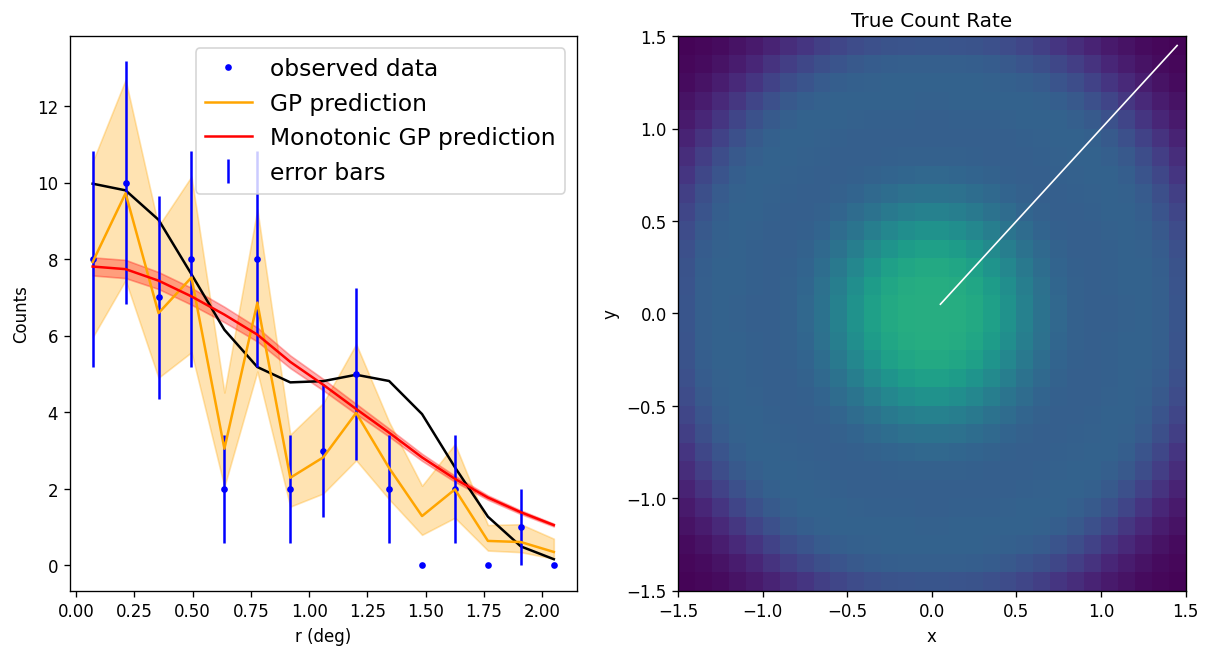

In [14]:
# Plot fit curves on a slice of increasing radius

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)

Nx = len(x1_c)
ny = np.arange(int(Nx/2),int(Nx),1)
y = rate

r = np.linalg.norm(x[ny,ny,:], axis = -1)
ax.plot(r, y[ny,ny], c = 'k')
ax.plot(r, y_obs[ny,ny], 'b.', label='observed data')
ax.errorbar(r, y_obs[ny,ny], yerr = np.sqrt(y_obs[ny,ny] ), c = 'b', fmt = 'none', label='error bars')
ax.plot(r, np.exp(mu_r)[ny,ny], c = 'orange', label = 'GP prediction')
ax.plot(r, np.exp(mu_c_r)[ny,ny], c = 'red', label = 'Monotonic GP prediction')
ax.fill_between(r, np.exp(mu_r - sigma_r)[ny,ny], np.exp(mu_r + sigma_r)[ny,ny], color = 'orange', alpha = 0.3)
ax.fill_between(r, np.exp(mu_c_r - sigma_c_r)[ny,ny], np.exp(mu_c_r + sigma_c_r)[ny,ny], color = 'red', alpha = 0.3)
ax.set_xlabel('r (deg)')
ax.set_ylabel('Counts')
ax.legend(fontsize = 14)

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax.plot(x[ny,ny,0], x[ny,ny,1], c = 'w', lw = 1)
ax.set_title('True Count Rate')
ax.set_xlabel('x')
ax.set_ylabel('y')



## Polar GP Fitting (Radial Derivative Regularization)

In [15]:
def cartesian_to_polar_(x,y):
    r = jnp.sqrt(x**2. + y**2.)
    theta = jnp.arctan2(y,x)
    return jnp.array([r,theta]).T

def Wendland_C2(t, tau, c):
    # tau >= 4
    T = t/c
    return (1. + tau * T) * jnp.power(1.-T, tau)

class AngularDistance(kernels.stationary.Distance):
    def distance(self, theta1, theta2):
        return jnp.arccos(jnp.cos(theta1 - theta2))
        
class GeodesicKernel(kernels.Kernel):
    def __init__(self, tau):
        self.tau = tau
        self.distance = AngularDistance()
    
    def evaluate(self, theta1, theta2):
        angular_distance = self.distance.distance(theta1, theta2)
        return Wendland_C2(angular_distance, self.tau, jnp.pi)    
    
class PolarKernel(kernels.Kernel):
    def __init__(self, kernel_r, kernel_ang, sigma, alpha1, alpha2):
        self.kernel_r = kernel_r
        self.kernel_ang = kernel_ang
        
        self.sigma = sigma
        self.alpha1 = alpha1
        self.alpha2 = alpha2
    
    def evaluate(self,X1,X2):
        rho1, theta1 = X1
        rho2, theta2 = X2
        
        return (self.sigma * 
                (1. + self.alpha1 * self.kernel_r.evaluate(rho1,rho2)) * 
                (1. + self.alpha2 * self.kernel_ang.evaluate(theta1,theta2)))

class DerivativePolarKernel(kernels.Kernel):
    def __init__(self, kernel_r, kernel_ang, sigma, alpha1, alpha2):
        self.kernel_r = kernel_r
        self.kernel_ang = kernel_ang
        
        self.sigma = sigma
        self.alpha1 = alpha1
        self.alpha2 = alpha2
    
    def evaluate(self,X1,X2):
        rho1, theta1, d1 = X1
        rho2, theta2, d2 = X2
        
        # Differentiate the kernel function: the first derivative wrt x1
        Kp = jax.grad(self.kernel_r.evaluate, argnums=0)
        # ... and the second derivative
        Kpp = jax.grad(Kp, argnums=1)
        # Evaluate the kernel matrix and all of its relevant derivatives
        K = self.kernel_r.evaluate(rho1, rho2)
        d2K_dx1dx2 = Kpp(rho1, rho2)
        # For stationary kernels, these are related just by a minus sign, but we'll
        # evaluate them both separately for generality's sake
        dK_dx2 = jax.grad(self.kernel_r.evaluate, argnums=1)(rho1, rho2)
        dK_dx1 = Kp(rho1, rho2)
        
        return ( self.sigma * (
                jnp.where(
                    d1, jnp.where(d2, self.alpha1 * d2K_dx1dx2, self.alpha1 * dK_dx1), 
                    jnp.where(d2, self.alpha1 * dK_dx2, 1. + self.alpha1 * K)
            ) )
                * (1. + self.alpha2 * self.kernel_ang.evaluate(theta1,theta2) )
               )

In [16]:
# compare sample of polar gp from cartesian gp

# load cartesian grid of inputs
x1_plt = np.linspace(-1.5, 1.5, 101)
x2_plt = np.linspace(-1.5, 1.5, 101)
x1_c = 0.5 * (x1_plt[1:] + x1_plt[:-1]) ; x2_c = 0.5 * (x2_plt[1:] + x2_plt[:-1])
x1, x2 = np.meshgrid(x1_c, x2_c)
x = np.stack([x1, x2], axis=-1)

# reshape data to (N_data,2)
Nx, Ny = x.shape[:-1]
x_f = x.reshape((Nx*Ny,2))

# convert grid coordinates to polar coordinates
x_f_polar = cartesian_to_polar_(x_f[:,0],x_f[:,1])

# define kernels
kernel_r = kernels.ExpSquared(scale = 0.1)
kernel_ang = GeodesicKernel(tau = 4.)
kernel = PolarKernel(kernel_r, kernel_ang, 1., 1., 1.)

# define kernels
gp_cartesian = GaussianProcess(kernel_r,x_f,diag = 1e-3)
gp_polar = GaussianProcess(kernel,x_f_polar,diag = 1e-3)

Text(0.5, 1.0, 'True Rate')

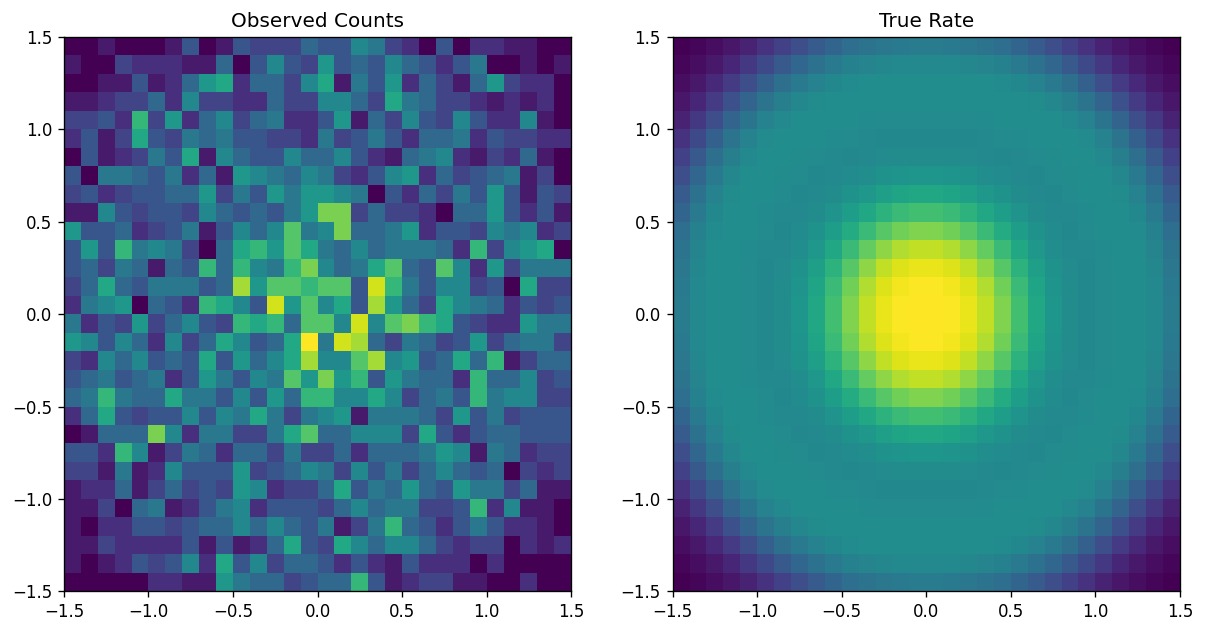

In [17]:
# plot the true function
x1_plt = np.linspace(-1.5, 1.5, 31)
x2_plt = np.linspace(-1.5, 1.5, 31)
x1_c = 0.5 * (x1_plt[1:] + x1_plt[:-1]) ; x2_c = 0.5 * (x2_plt[1:] + x2_plt[:-1])
x1, x2 = np.meshgrid(x1_c, x2_c)
x = np.stack([x1, x2], axis=-1)
x_mag = np.linalg.norm(x, axis = -1)
log_rate = -0.4 * x_mag**2. * np.abs(2. + np.cos(8. * x_mag**(0.5)))
rate = 10 * np.exp(log_rate)
y_obs = np.random.poisson(rate)

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)
ax.pcolormesh(x1_plt, x2_plt, y_obs, cmap='viridis')
ax.set_title('Observed Counts')

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, rate, cmap='viridis')
ax.set_title('True Rate')

Text(0, 0.5, 'y')

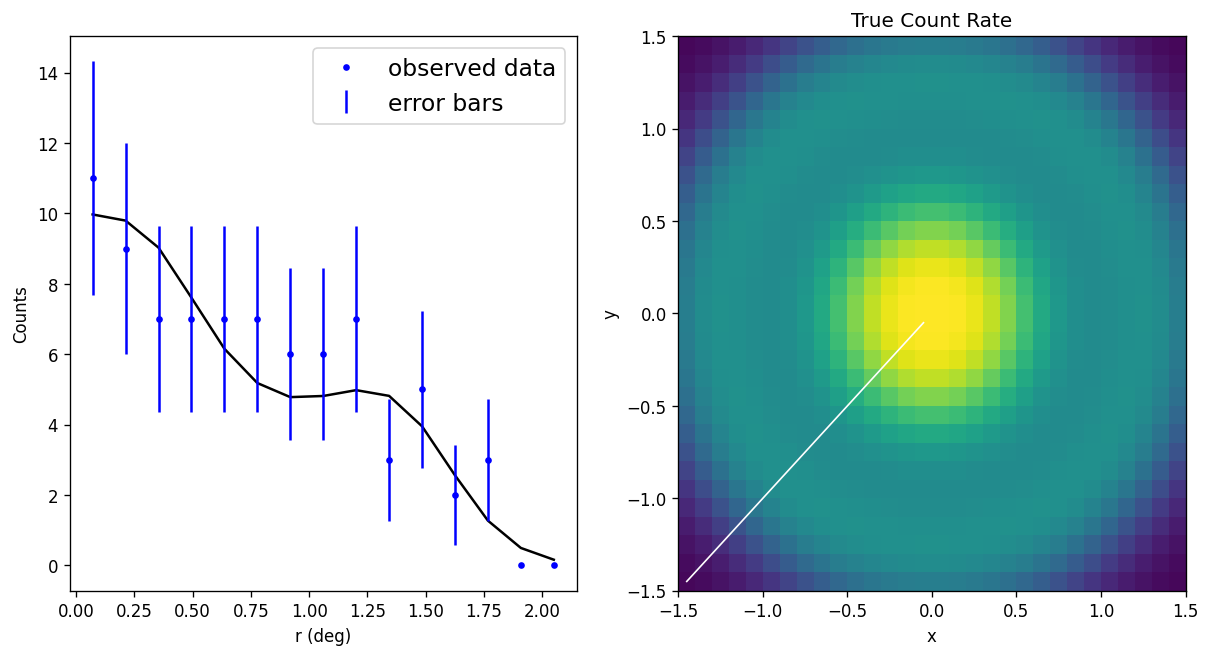

In [18]:
# Plot fit curves on a slice of x-values

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)

Nx = len(x1_c)
ny = np.arange(0,int(Nx/2),1)
y = rate

r = np.linalg.norm(x[ny,ny,:], axis = -1)
ax.plot(r, y[ny,ny], c = 'k')
ax.plot(r, y_obs[ny,ny], 'b.', label='observed data')
ax.errorbar(r, y_obs[ny,ny], yerr = np.sqrt(y_obs[ny,ny] ), c = 'b', fmt = 'none', label='error bars')
ax.set_xlabel('r (deg)')
ax.set_ylabel('Counts')
ax.legend(fontsize = 14)

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=np.max(y)))
ax.plot(x[ny,ny,0], x[ny,ny,1], c = 'w', lw = 1)
ax.set_title('True Count Rate')
ax.set_xlabel('x')
ax.set_ylabel('y')

In [19]:
# SVI fit to 2D Poisson data with Gaussian Process prior
# on log_rate and its derivatives, NOT subject to derivative-regularization

# NOTE: To use different kernels, need to change distance as in 02_2d_deriv_gp.ipynb

Nx, Ny = x.shape[:-1]
x_f = x.reshape((Nx*Ny,2))
x_f_polar = cartesian_to_polar_(x_f[:,0], x_f[:,1])
y_obs_f = y_obs.reshape((Nx*Ny,))

jax.config.update("jax_enable_x64", False)
jax.config.update("jax_debug_nans", False)

def model(x, y=None):
    Nx = x.shape[0]
    Nx2 = 2 * Nx

    log_scale_r = numpyro.param('log_scale_r', jnp.zeros(()))
    log_tau_offset = numpyro.param('log_tau_offset', jnp.zeros(()))
    
    log_sigma = numpyro.param('log_sigma', jnp.zeros(()))
    log_alpha1 = numpyro.param('log_alpha1', jnp.zeros(()))
    log_alpha2 = numpyro.param('log_alpha2', jnp.zeros(()))
    
    scale_r = jnp.exp(log_scale_r)
    tau = 4. + jnp.exp(log_tau_offset)
    sigma = jnp.exp(log_sigma)
    alpha1 = jnp.exp(log_alpha1)
    alpha2 = jnp.exp(log_alpha2)
    
    # augment data
    x2 = jnp.concatenate([x,x])
    d2x = jnp.concatenate([jnp.zeros(x.shape[0]),jnp.ones(x.shape[0])])
    x_aug = jnp.vstack([x2.T,d2x.T]).T

    # load joint kernel from the original function kernel
    kernel_r = kernels.ExpSquared(scale = scale_r)
    kernel_ang = GeodesicKernel(tau = tau)
    kernel = DerivativePolarKernel(kernel_r, kernel_ang, sigma, alpha1, alpha2)
    gp = GaussianProcess(kernel, x_aug[:Nx], diag=1e-3) 

    # sample log_rate from GP
    log_rate = numpyro.sample("log_rate", gp.numpyro_dist())

    # define the likelihood
    rate = jnp.exp(log_rate)
    numpyro.sample("obs", dist.Poisson(rate), obs=y) # can't use numpyro.factor for svi

# guide of posterior distribution of log_rate and log_rate_deriv
def guide(x, y=None):
    mu = numpyro.param(
        "log_rate_mu", jnp.zeros((x.shape[0],))
    )
    sigma = numpyro.param(
        "log_rate_sigma",
        jnp.ones((x.shape[0],)),
        constraint=dist.constraints.positive,
    )

    numpyro.sample("log_rate", dist.Independent(dist.Normal(mu, sigma), 1))

# run SVI
optim = numpyro.optim.Adam(0.01)
svi = numpyro.infer.SVI(model, guide, optim, numpyro.infer.Trace_ELBO(10))
results = svi.run(jax.random.PRNGKey(5573), 12000, x_f_polar, y=y_obs_f, progress_bar=True)

100%|██████████| 12000/12000 [00:46<00:00, 258.07it/s, init loss: 350087.7500, avg. loss [11401-12000]: 1957.1343]


In [20]:
# load optimized guide params
mu = results.params["log_rate_mu"]
sigma = results.params["log_rate_sigma"]

mu_r = mu.reshape(Nx,Ny)
sigma_r = sigma.reshape(Nx,Ny)

Text(0.5, 1.0, 'Counts')

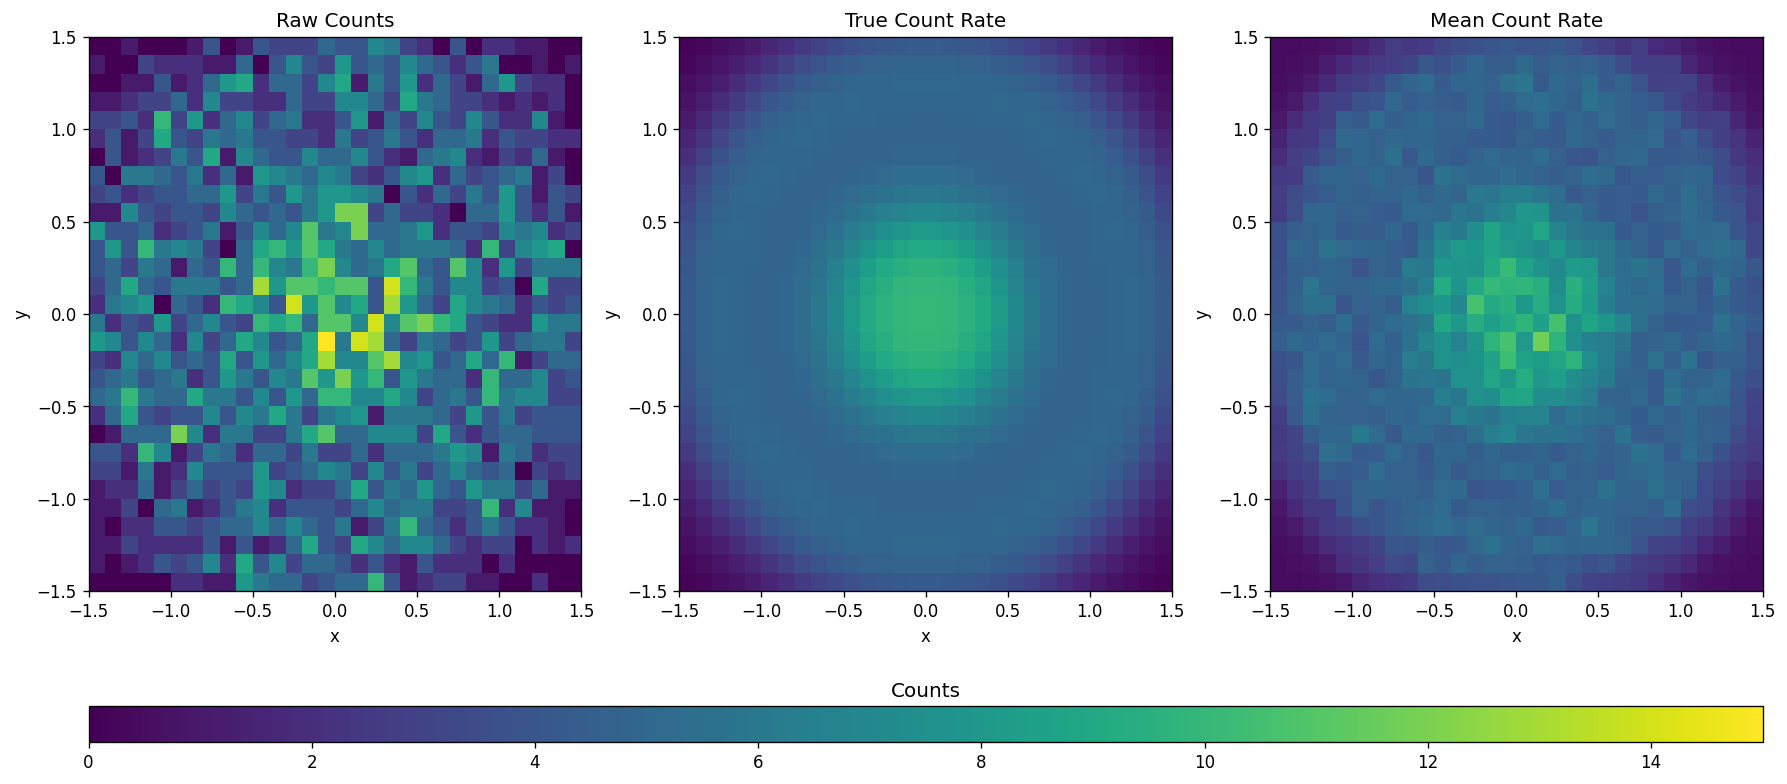

In [21]:
# plot raw count map, true rate map, and mean rate map from posterior of log_rate

vmax = np.max([np.max(y_obs), np.max(rate), np.max(np.exp(mu_r))])
fig = plt.figure(figsize=(18, 6), dpi= 120)
ax1 = fig.add_subplot(131)
plot1 = plt.pcolormesh(x1_plt, x2_plt, y_obs, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax1.set_title('Raw Counts')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2 = fig.add_subplot(132)
plot2 = plt.pcolormesh(x1_plt, x2_plt, rate, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax2.set_title('True Count Rate')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax3 = fig.add_subplot(133)
plot3 = plt.pcolormesh(x1_plt, x2_plt, np.exp(mu_r), cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax3.set_title('Mean Count Rate')
ax3.set_xlabel('x')
ax3.set_ylabel('y')

p0 = ax1.get_position().get_points().flatten()
p1 = ax2.get_position().get_points().flatten()
p2 = ax3.get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], -0.1, p2[2]-p0[0], 0.05])

plt.colorbar(cax=ax_cbar, orientation='horizontal')
ax_cbar.set_title('Counts')

Text(0, 0.5, 'y')

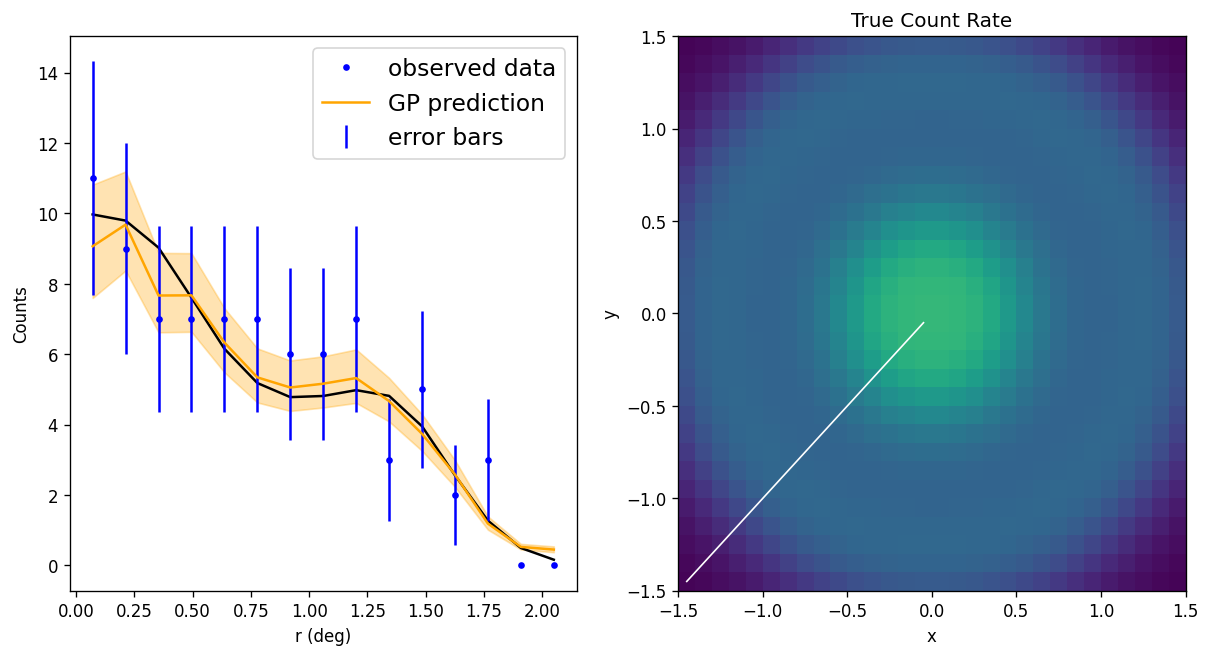

In [22]:
# Plot fit curves on a slice of increasing radius

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)

Nx = len(x1_c)
ny = np.arange(0,int(Nx/2),1)
y = rate

r = np.linalg.norm(x[ny,ny,:], axis = -1)
ax.plot(r, y[ny,ny], c = 'k')
ax.plot(r, y_obs[ny,ny], 'b.', label='observed data')
ax.errorbar(r, y_obs[ny,ny], yerr = np.sqrt(y_obs[ny,ny] ), c = 'b', fmt = 'none', label='error bars')
ax.plot(r, np.exp(mu_r)[ny,ny], c = 'orange', label = 'GP prediction')
ax.fill_between(r, np.exp(mu_r - sigma_r)[ny,ny], np.exp(mu_r + sigma_r)[ny,ny], color = 'orange', alpha = 0.3)
ax.set_xlabel('r (deg)')
ax.set_ylabel('Counts')
ax.legend(fontsize = 14)

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax.plot(x[ny,ny,0], x[ny,ny,1], c = 'w', lw = 1)
ax.set_title('True Count Rate')
ax.set_xlabel('x')
ax.set_ylabel('y')

Text(0, 0.5, 'y')

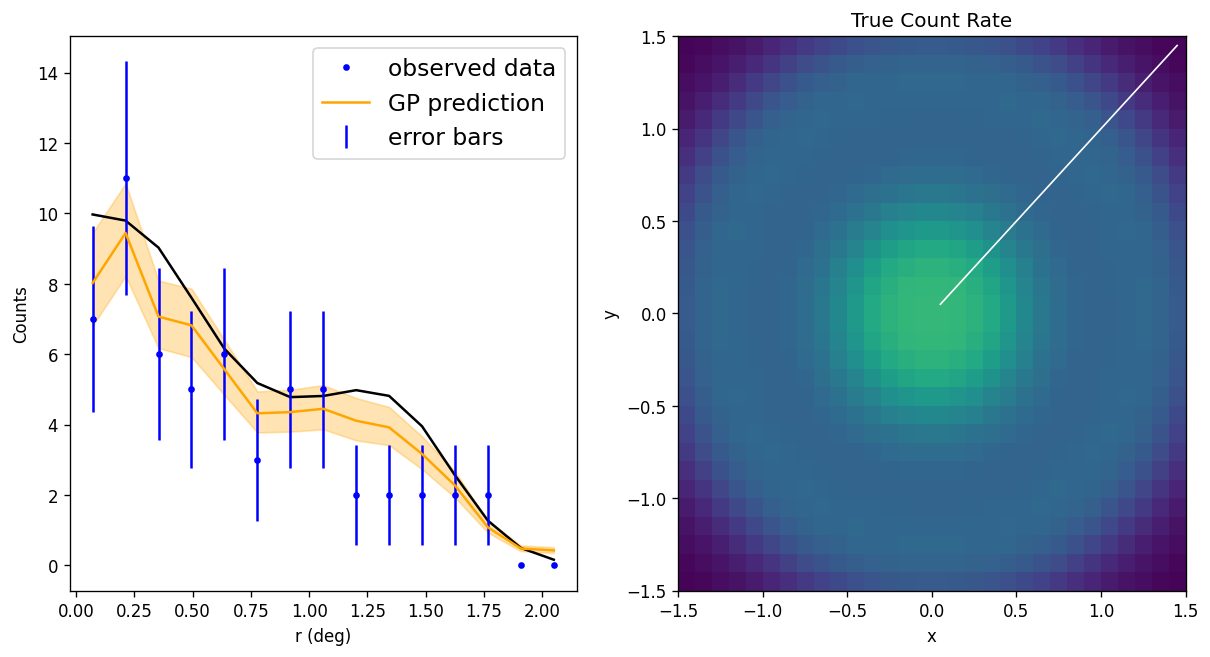

In [23]:
# Plot fit curves on a slice of increasing radius

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)

Nx = len(x1_c)
ny = np.arange(int(Nx/2),int(Nx),1)
y = rate

r = np.linalg.norm(x[ny,ny,:], axis = -1)
ax.plot(r, y[ny,ny], c = 'k')
ax.plot(r, y_obs[ny,ny], 'b.', label='observed data')
ax.errorbar(r, y_obs[ny,ny], yerr = np.sqrt(y_obs[ny,ny] ), c = 'b', fmt = 'none', label='error bars')
ax.plot(r, np.exp(mu_r)[ny,ny], c = 'orange', label = 'GP prediction')
ax.fill_between(r, np.exp(mu_r - sigma_r)[ny,ny], np.exp(mu_r + sigma_r)[ny,ny], color = 'orange', alpha = 0.3)
ax.set_xlabel('r (deg)')
ax.set_ylabel('Counts')
ax.legend(fontsize = 14)

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax.plot(x[ny,ny,0], x[ny,ny,1], c = 'w', lw = 1)
ax.set_title('True Count Rate')
ax.set_xlabel('x')
ax.set_ylabel('y')



In [24]:
# SVI fit to 2D Poisson data with Gaussian Process prior
# on log_rate and its derivatives, subject to derivative-regularization

# NOTE: To use different kernels, need to change distance as in 02_2d_deriv_gp.ipynb

Nx, Ny = x.shape[:-1]
x_f = x.reshape((Nx*Ny,2))
y_obs_f = y_obs.reshape((Nx*Ny,))

jax.config.update("jax_enable_x64", False)

def model(x, y=None):
    Nx = x.shape[0]
    Nx2 = 2 * Nx

    log_scale_r = numpyro.param('log_scale_r', jnp.zeros(()))
    log_tau_offset = numpyro.param('log_tau_offset', jnp.zeros(()))
    
    log_sigma = numpyro.param('log_sigma', jnp.zeros(()))
    log_alpha1 = numpyro.param('log_alpha1', jnp.zeros(()))
    log_alpha2 = numpyro.param('log_alpha2', jnp.zeros(()))
    
    scale_r = jnp.exp(log_scale_r)
    tau = 4. + jnp.exp(log_tau_offset)
    sigma = jnp.exp(log_sigma)
    alpha1 = jnp.exp(log_alpha1)
    alpha2 = jnp.exp(log_alpha2)
    
    # augment data
    x2 = jnp.concatenate([x,x])
    d2x = jnp.concatenate([jnp.zeros(x.shape[0]),jnp.ones(x.shape[0])])
    x_aug = jnp.vstack([x2.T,d2x.T]).T

    # load joint kernel from the original function kernel
    kernel_r = kernels.ExpSquared(scale = scale_r)
    kernel_ang = GeodesicKernel(tau = tau)
    kernel = DerivativePolarKernel(kernel_r, kernel_ang, sigma, alpha1, alpha2)
    gp = GaussianProcess(kernel, x_aug[:Nx], diag=1e-3) 

    # sample log_rate from GP
    log_rate = numpyro.sample("log_rate", gp.numpyro_dist())

    # define the likelihood
    rate = jnp.exp(log_rate)
    numpyro.sample("obs", dist.Poisson(rate), obs=y) # can't use numpyro.factor for svi

    # sample log_rate_px from GP conditioned on log_rate
    _, gp_cond_p = gp.condition(log_rate, x_aug[Nx:Nx2],diag=1e-3) # condition GP on log_rate and sample derivatives at x_aug[Nx:]
    log_rate_p = gp_cond_p.sample(jax.random.PRNGKey(5573)) # log_rate_deriv 
    rate_p = rate * log_rate_p # rate_deriv

    # define the constraint
    numpyro.factor("constraint", -10. * jnp.sum(jnp.where(rate_p > 0, rate_p, 0.)))

# guide of posterior distribution of log_rate and log_rate_deriv
def guide(x, y=None):
    mu = numpyro.param(
        "log_rate_mu", jnp.zeros((x.shape[0],))
    )
    sigma = numpyro.param(
        "log_rate_sigma",
        jnp.ones((x.shape[0],)),
        constraint=dist.constraints.positive,
    )

    numpyro.sample("log_rate", dist.Independent(dist.Normal(mu, sigma), 1))

# run SVI
optim = numpyro.optim.Adam(0.01)
svi = numpyro.infer.SVI(model, guide, optim, numpyro.infer.Trace_ELBO(10))
results = svi.run(jax.random.PRNGKey(5573), 12000, x_f_polar, y=y_obs_f, progress_bar=True)

100%|██████████| 12000/12000 [02:06<00:00, 94.54it/s, init loss: 357715.5938, avg. loss [11401-12000]: 1957.2795]


In [25]:
# load optimized guide params
mu_c = results.params["log_rate_mu"]
sigma_c = results.params["log_rate_sigma"]

mu_c_r = mu_c.reshape(Nx,Ny)
sigma_c_r = sigma_c.reshape(Nx,Ny)

Text(0.5, 1.0, 'Counts')

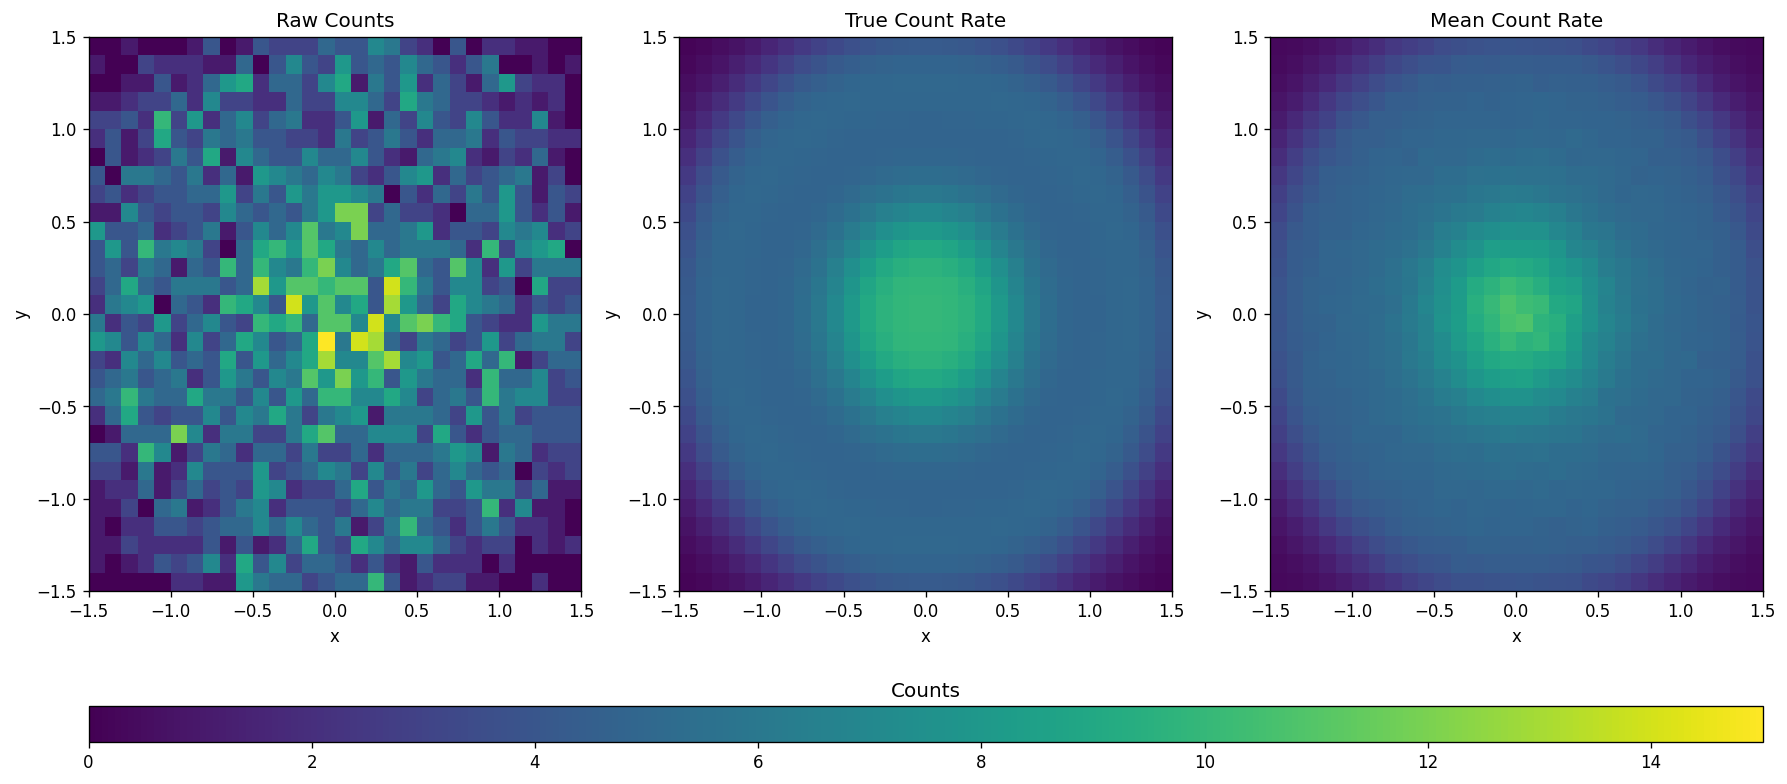

In [26]:
# plot raw count map, true rate map, and mean rate map from posterior of log_rate

import matplotlib as mpl

vmax = np.max([np.max(y_obs), np.max(rate), np.max(np.exp(mu_c_r))])
fig = plt.figure(figsize=(18, 6), dpi= 120)
ax1 = fig.add_subplot(131)
plot1 = plt.pcolormesh(x1_plt, x2_plt, y_obs, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax1.set_title('Raw Counts')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2 = fig.add_subplot(132)
plot2 = plt.pcolormesh(x1_plt, x2_plt, rate, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax2.set_title('True Count Rate')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax3 = fig.add_subplot(133)
plot3 = plt.pcolormesh(x1_plt, x2_plt, np.exp(mu_c_r), cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax3.set_title('Mean Count Rate')
ax3.set_xlabel('x')
ax3.set_ylabel('y')

p0 = ax1.get_position().get_points().flatten()
p1 = ax2.get_position().get_points().flatten()
p2 = ax3.get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], -0.1, p2[2]-p0[0], 0.05])

plt.colorbar(cax=ax_cbar, orientation='horizontal')
ax_cbar.set_title('Counts')

Text(0, 0.5, 'y')

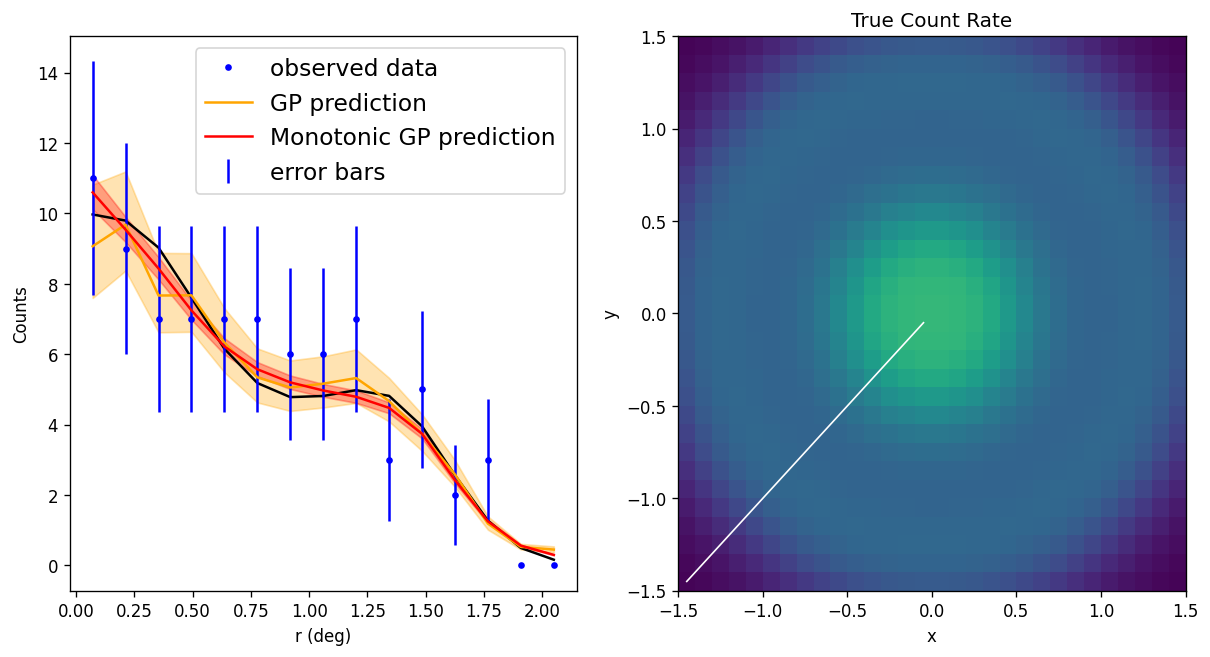

In [27]:
# Plot fit curves on a slice of increasing radius

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)

Nx = len(x1_c)
ny = np.arange(0,int(Nx/2),1)
y = rate

r = np.linalg.norm(x[ny,ny,:], axis = -1)
ax.plot(r, y[ny,ny], c = 'k')
ax.plot(r, y_obs[ny,ny], 'b.', label='observed data')
ax.errorbar(r, y_obs[ny,ny], yerr = np.sqrt(y_obs[ny,ny] ), c = 'b', fmt = 'none', label='error bars')
ax.plot(r, np.exp(mu_r)[ny,ny], c = 'orange', label = 'GP prediction')
ax.plot(r, np.exp(mu_c_r)[ny,ny], c = 'red', label = 'Monotonic GP prediction')
ax.fill_between(r, np.exp(mu_r - sigma_r)[ny,ny], np.exp(mu_r + sigma_r)[ny,ny], color = 'orange', alpha = 0.3)
ax.fill_between(r, np.exp(mu_c_r - sigma_c_r)[ny,ny], np.exp(mu_c_r + sigma_c_r)[ny,ny], color = 'red', alpha = 0.3)
ax.set_xlabel('r (deg)')
ax.set_ylabel('Counts')
ax.legend(fontsize = 14)

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax.plot(x[ny,ny,0], x[ny,ny,1], c = 'w', lw = 1)
ax.set_title('True Count Rate')
ax.set_xlabel('x')
ax.set_ylabel('y')

Text(0, 0.5, 'y')

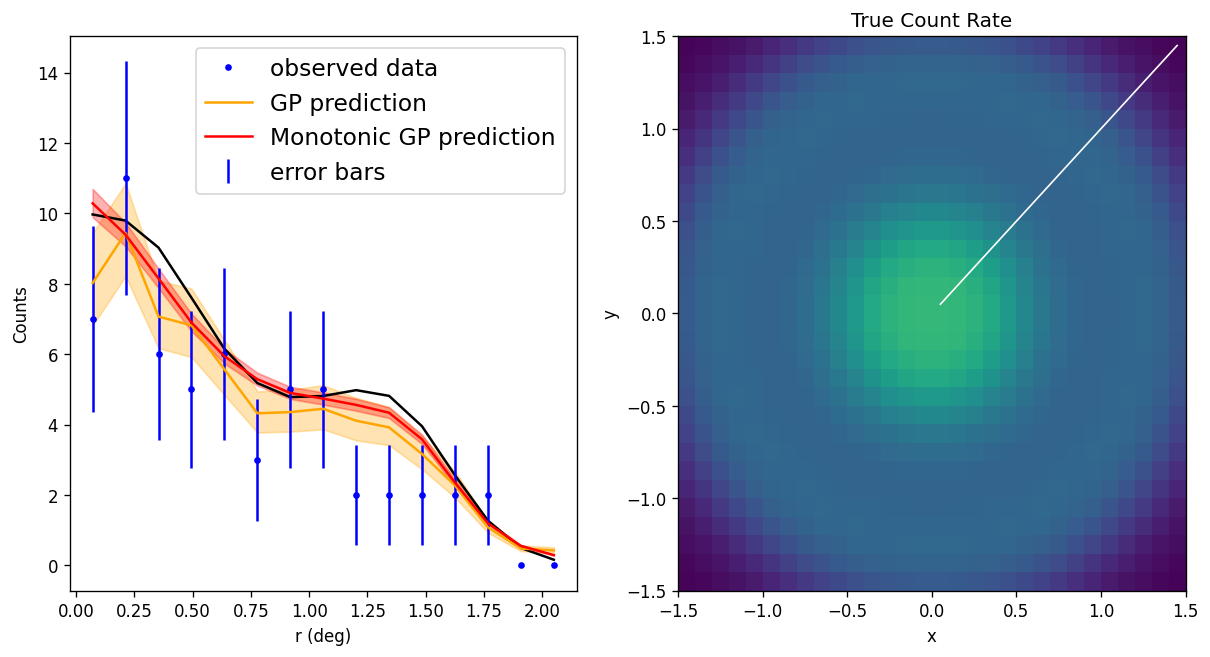

In [28]:
# Plot fit curves on a slice of increasing radius

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)

Nx = len(x1_c)
ny = np.arange(int(Nx/2),int(Nx),1)
y = rate

r = np.linalg.norm(x[ny,ny,:], axis = -1)
ax.plot(r, y[ny,ny], c = 'k')
ax.plot(r, y_obs[ny,ny], 'b.', label='observed data')
ax.errorbar(r, y_obs[ny,ny], yerr = np.sqrt(y_obs[ny,ny] ), c = 'b', fmt = 'none', label='error bars')
ax.plot(r, np.exp(mu_r)[ny,ny], c = 'orange', label = 'GP prediction')
ax.plot(r, np.exp(mu_c_r)[ny,ny], c = 'red', label = 'Monotonic GP prediction')
ax.fill_between(r, np.exp(mu_r - sigma_r)[ny,ny], np.exp(mu_r + sigma_r)[ny,ny], color = 'orange', alpha = 0.3)
ax.fill_between(r, np.exp(mu_c_r - sigma_c_r)[ny,ny], np.exp(mu_c_r + sigma_c_r)[ny,ny], color = 'red', alpha = 0.3)
ax.set_xlabel('r (deg)')
ax.set_ylabel('Counts')
ax.legend(fontsize = 14)

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax.plot(x[ny,ny,0], x[ny,ny,1], c = 'w', lw = 1)
ax.set_title('True Count Rate')
ax.set_xlabel('x')
ax.set_ylabel('y')

